In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fer2013' dataset.
Path to dataset files: /kaggle/input/fer2013


In [2]:
import torch
from torchvision import transforms , datasets
from torch.utils.data import DataLoader

In [3]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt

In [4]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])  # normalize
])


In [5]:
train_path = "/kaggle/input/fer2013/train"
test_path = "/kaggle/input/fer2013/test"

In [6]:
train_dataset = datasets.ImageFolder(train_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path , transform=transform)

In [7]:
train_loader = DataLoader(train_dataset , batch_size=32 , shuffle=True)
test_loader = DataLoader(test_dataset , batch_size=32 , shuffle=False)

In [8]:
train_dataset.class_to_idx

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [9]:
train_dataset.classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

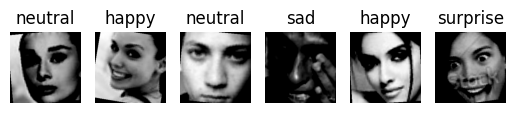

In [10]:
import matplotlib.pyplot as plt

images , labels = next(iter(train_loader))

# fig , axes = plt.subplot()

for i in range(6):
    img = images[i].permute(1,2,0).numpy()
    plt.subplot(1,6,i+1)
    plt.imshow(img , cmap="gray")
    plt.title(train_dataset.classes[labels[i]])
    plt.axis(False)
plt.show()

In [11]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # print(x.shape)
        x = self.features(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        # print(x.shape)
        x = self.classifier(x)
        return x


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN(num_classes=7).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [13]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        # -----------------
        # Training Phase
        # -----------------
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        # -----------------
        # Evaluation Phase
        # -----------------
        model.eval()
        test_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_loss /= len(test_loader)
        test_acc = 100 * correct / total

        print(f"Epoch {epoch+1}/{epochs} "
              f"| Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
              f"| Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


In [13]:
train_model(model, train_loader,test_loader , criterion, optimizer, epochs=10)


Epoch 1/10 | Train Loss: 1.6963, Train Acc: 31.46% | Test Loss: 1.5142, Test Acc: 41.84%
Epoch 2/10 | Train Loss: 1.4583, Train Acc: 43.47% | Test Loss: 1.3459, Test Acc: 47.62%
Epoch 3/10 | Train Loss: 1.3447, Train Acc: 48.16% | Test Loss: 1.2864, Test Acc: 50.21%
Epoch 4/10 | Train Loss: 1.2791, Train Acc: 50.92% | Test Loss: 1.2318, Test Acc: 52.22%
Epoch 5/10 | Train Loss: 1.2303, Train Acc: 52.98% | Test Loss: 1.2154, Test Acc: 53.32%
Epoch 6/10 | Train Loss: 1.1894, Train Acc: 54.43% | Test Loss: 1.1843, Test Acc: 54.78%
Epoch 7/10 | Train Loss: 1.1638, Train Acc: 55.83% | Test Loss: 1.2048, Test Acc: 54.46%
Epoch 8/10 | Train Loss: 1.1336, Train Acc: 56.88% | Test Loss: 1.1757, Test Acc: 54.26%
Epoch 9/10 | Train Loss: 1.1032, Train Acc: 57.68% | Test Loss: 1.1675, Test Acc: 55.06%
Epoch 10/10 | Train Loss: 1.0864, Train Acc: 58.86% | Test Loss: 1.1706, Test Acc: 55.18%


In [15]:
from pathlib import Path

model_save_path = "/content/models"
torch.save(model.state_dict(), Path(model_save_path,"BaselineCNN.pth"))

In [16]:
import torchvision.models as models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet
ResNet18_model = models.resnet18(pretrained=True)

# Modify input layer (for 1-channel grayscale → 3-channel workaround)
ResNet18_model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Replace final layer
num_features = ResNet18_model.fc.in_features
ResNet18_model.fc = nn.Linear(num_features, 7)  # 7 emotions

# Freeze earlier layers (transfer learning)
for param in ResNet18_model.parameters():
    param.requires_grad = False
for param in ResNet18_model.fc.parameters():
    param.requires_grad = True

ResNet18_model=ResNet18_model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


In [17]:
optimizer = torch.optim.Adam(ResNet18_model.fc.parameters(), lr=1e-4, weight_decay=1e-5)

In [18]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extract all labels from your dataset
train_labels = [label for _, label in train_dataset]  # if train_dataset is a torchvision dataset

# Compute weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to tensor for PyTorch
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use in loss
criterion = nn.CrossEntropyLoss(weight=class_weights)


In [19]:
print("Model device:", next(ResNet18_model.parameters()).device)
print("Weights device:", class_weights.device)

Model device: cuda:0
Weights device: cuda:0


In [20]:
train_model(ResNet18_model, train_loader,test_loader, criterion, optimizer, epochs=10)

Epoch 1/10 | Train Loss: 1.9293, Train Acc: 21.45% | Test Loss: 1.8391, Test Acc: 26.29%
Epoch 2/10 | Train Loss: 1.8470, Train Acc: 27.74% | Test Loss: 1.7724, Test Acc: 30.38%
Epoch 3/10 | Train Loss: 1.8082, Train Acc: 30.11% | Test Loss: 1.7715, Test Acc: 31.16%
Epoch 4/10 | Train Loss: 1.7858, Train Acc: 31.17% | Test Loss: 1.7442, Test Acc: 32.95%
Epoch 5/10 | Train Loss: 1.7726, Train Acc: 32.23% | Test Loss: 1.7462, Test Acc: 32.43%
Epoch 6/10 | Train Loss: 1.7560, Train Acc: 32.48% | Test Loss: 1.7707, Test Acc: 30.73%
Epoch 7/10 | Train Loss: 1.7529, Train Acc: 32.78% | Test Loss: 1.7733, Test Acc: 30.04%
Epoch 8/10 | Train Loss: 1.7410, Train Acc: 33.29% | Test Loss: 1.7257, Test Acc: 33.24%
Epoch 9/10 | Train Loss: 1.7352, Train Acc: 33.54% | Test Loss: 1.7355, Test Acc: 32.60%
Epoch 10/10 | Train Loss: 1.7287, Train Acc: 33.56% | Test Loss: 1.7095, Test Acc: 33.73%


In [21]:
from pathlib import Path
model_save_path = "/content/models"
torch.save(ResNet18_model.state_dict(), Path(model_save_path,"ResNet18.pth"))

In [22]:
ResNet50_model = models.resnet50(pretrained=True)

# Freeze early layers
for param in ResNet50_model.parameters():
    param.requires_grad = False

# Replace last layer
num_features = ResNet50_model.fc.in_features
ResNet50_model.fc = nn.Linear(num_features, 7)  # 7 emotion classes


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ResNet50_model = ResNet50_model.to(device)

# --------------------------
# Compute Class Weights
# --------------------------
train_labels = [label for _, label in train_dataset]  # get all labels from dataset
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

# --------------------------
# Step 1: Freeze all except final layer
# --------------------------
for param in ResNet50_model.parameters():
    param.requires_grad = False
for param in ResNet50_model.fc.parameters():
    param.requires_grad = True

optimizer = optim.Adam(ResNet50_model.fc.parameters(), lr=1e-3)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 78.7MB/s]


In [23]:
train_model(ResNet50_model, train_loader,test_loader, criterion, optimizer, epochs=10)


Epoch 1/10 | Train Loss: 1.7936, Train Acc: 31.03% | Test Loss: 1.5917, Test Acc: 39.63%
Epoch 2/10 | Train Loss: 1.7053, Train Acc: 35.58% | Test Loss: 1.7376, Test Acc: 33.52%
Epoch 3/10 | Train Loss: 1.6820, Train Acc: 36.54% | Test Loss: 1.6885, Test Acc: 34.58%
Epoch 4/10 | Train Loss: 1.6600, Train Acc: 37.50% | Test Loss: 1.6048, Test Acc: 38.16%
Epoch 5/10 | Train Loss: 1.6454, Train Acc: 37.82% | Test Loss: 1.6718, Test Acc: 35.79%
Epoch 6/10 | Train Loss: 1.6503, Train Acc: 37.78% | Test Loss: 1.6265, Test Acc: 37.45%
Epoch 7/10 | Train Loss: 1.6520, Train Acc: 38.06% | Test Loss: 1.6443, Test Acc: 37.74%
Epoch 8/10 | Train Loss: 1.6390, Train Acc: 38.27% | Test Loss: 1.5063, Test Acc: 41.24%
Epoch 9/10 | Train Loss: 1.6260, Train Acc: 38.90% | Test Loss: 1.5808, Test Acc: 38.84%
Epoch 10/10 | Train Loss: 1.6164, Train Acc: 39.43% | Test Loss: 1.6647, Test Acc: 36.25%


In [24]:
# Step 3: Unfreeze Last Block (layer4)
# --------------------------
for name, param in ResNet50_model.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

optimizer = optim.Adam([
    {"params": ResNet50_model.fc.parameters(), "lr": 1e-3},
    {"params": ResNet50_model.layer4.parameters(), "lr": 1e-5}
])

print("🔹 Fine-tuning layer4...")
train_model(ResNet50_model, train_loader, test_loader, criterion, optimizer, epochs=10)


🔹 Fine-tuning layer4...
Epoch 1/10 | Train Loss: 1.5680, Train Acc: 42.08% | Test Loss: 1.4787, Test Acc: 44.00%
Epoch 2/10 | Train Loss: 1.3964, Train Acc: 47.59% | Test Loss: 1.3672, Test Acc: 48.54%
Epoch 3/10 | Train Loss: 1.2999, Train Acc: 50.95% | Test Loss: 1.2955, Test Acc: 53.22%
Epoch 4/10 | Train Loss: 1.2275, Train Acc: 53.61% | Test Loss: 1.3093, Test Acc: 51.41%
Epoch 5/10 | Train Loss: 1.1665, Train Acc: 55.28% | Test Loss: 1.3780, Test Acc: 49.94%
Epoch 6/10 | Train Loss: 1.1089, Train Acc: 56.85% | Test Loss: 1.1731, Test Acc: 56.14%
Epoch 7/10 | Train Loss: 1.0522, Train Acc: 58.69% | Test Loss: 1.2049, Test Acc: 57.11%
Epoch 8/10 | Train Loss: 1.0169, Train Acc: 59.91% | Test Loss: 1.1729, Test Acc: 57.82%
Epoch 9/10 | Train Loss: 0.9837, Train Acc: 60.92% | Test Loss: 1.2577, Test Acc: 54.85%
Epoch 10/10 | Train Loss: 0.9556, Train Acc: 62.34% | Test Loss: 1.3470, Test Acc: 52.70%


In [25]:
# --------------------------
# Step 4 (Optional): Unfreeze layer3 as well
# --------------------------
for name, param in ResNet50_model.named_parameters():
    if "layer3" in name:
        param.requires_grad = True

optimizer = optim.Adam([
    {"params": ResNet50_model.fc.parameters(), "lr": 1e-3},
    {"params": ResNet50_model.layer4.parameters(), "lr": 1e-5},
    {"params": ResNet50_model.layer3.parameters(), "lr": 1e-5}
])

print("🔹 Fine-tuning layer3 + layer4...")
train_model(ResNet50_model, train_loader, test_loader, criterion, optimizer, epochs=10)

🔹 Fine-tuning layer3 + layer4...
Epoch 1/10 | Train Loss: 0.9229, Train Acc: 63.60% | Test Loss: 1.1319, Test Acc: 60.02%
Epoch 2/10 | Train Loss: 0.8623, Train Acc: 65.99% | Test Loss: 1.1850, Test Acc: 59.72%
Epoch 3/10 | Train Loss: 0.8133, Train Acc: 68.19% | Test Loss: 1.1370, Test Acc: 60.80%
Epoch 4/10 | Train Loss: 0.7647, Train Acc: 69.34% | Test Loss: 1.1131, Test Acc: 61.62%
Epoch 5/10 | Train Loss: 0.7214, Train Acc: 71.10% | Test Loss: 1.1489, Test Acc: 61.67%
Epoch 6/10 | Train Loss: 0.6827, Train Acc: 73.01% | Test Loss: 1.1121, Test Acc: 62.90%
Epoch 7/10 | Train Loss: 0.6321, Train Acc: 74.80% | Test Loss: 1.1466, Test Acc: 63.28%
Epoch 8/10 | Train Loss: 0.6004, Train Acc: 76.12% | Test Loss: 1.2106, Test Acc: 62.29%
Epoch 9/10 | Train Loss: 0.5563, Train Acc: 77.73% | Test Loss: 1.1886, Test Acc: 64.32%
Epoch 10/10 | Train Loss: 0.5181, Train Acc: 79.41% | Test Loss: 1.2243, Test Acc: 62.96%


In [27]:
train_model(ResNet50_model, train_loader, test_loader, criterion, optimizer, epochs=10)

Epoch 1/10 | Train Loss: 0.4834, Train Acc: 80.66% | Test Loss: 1.2321, Test Acc: 64.54%
Epoch 2/10 | Train Loss: 0.4328, Train Acc: 82.74% | Test Loss: 1.2859, Test Acc: 64.03%
Epoch 3/10 | Train Loss: 0.4239, Train Acc: 83.13% | Test Loss: 1.3856, Test Acc: 63.42%
Epoch 4/10 | Train Loss: 0.3853, Train Acc: 84.80% | Test Loss: 1.3878, Test Acc: 63.82%
Epoch 5/10 | Train Loss: 0.3467, Train Acc: 86.02% | Test Loss: 1.5013, Test Acc: 62.57%
Epoch 6/10 | Train Loss: 0.3312, Train Acc: 87.09% | Test Loss: 1.4633, Test Acc: 64.50%
Epoch 7/10 | Train Loss: 0.3099, Train Acc: 87.89% | Test Loss: 1.4772, Test Acc: 64.91%
Epoch 8/10 | Train Loss: 0.2699, Train Acc: 89.34% | Test Loss: 1.5222, Test Acc: 65.07%
Epoch 9/10 | Train Loss: 0.2422, Train Acc: 90.14% | Test Loss: 1.5708, Test Acc: 64.61%
Epoch 10/10 | Train Loss: 0.2571, Train Acc: 89.82% | Test Loss: 1.5969, Test Acc: 65.60%


In [ ]:
for name, param in ResNet50_model.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

optimizer = optim.Adam([
    {"params": ResNet50_model.fc.parameters(), "lr": 1e-3},
    {"params": ResNet50_model.layer4.parameters(), "lr": 1e-5}
])

print("🔹 Fine-tuning layer4...")
train_model(ResNet50_model, train_loader, test_loader, criterion, optimizer, epochs=5)

In [28]:
from pathlib import Path
model_save_path = "/content/models"
torch.save(ResNet50_model.state_dict(), Path(model_save_path,"ResNet50.pth"))